## Importing Data & Exploration

In [114]:
# General setup imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Regression analysis tools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import RFE
import statsmodels.api as sm
from stepwise_selection import stepwise_selection
from sklearn.model_selection import cross_val_score

%matplotlib inline
plt.style.use('fivethirtyeight')

In [115]:
np.random.seed(3)

In [116]:
kc_housing = pd.read_csv('kc_house_data.csv')
kc_housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [117]:
# Looking at columns type and if complete, and viewing which columns have null values that need to be addressed.
kc_housing.isna().sum(), kc_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


(id                  0
 date                0
 price               0
 bedrooms            0
 bathrooms           0
 sqft_living         0
 sqft_lot            0
 floors              0
 waterfront       2376
 view               63
 condition           0
 grade               0
 sqft_above          0
 sqft_basement       0
 yr_built            0
 yr_renovated     3842
 zipcode             0
 lat                 0
 long                0
 sqft_living15       0
 sqft_lot15          0
 dtype: int64, None)

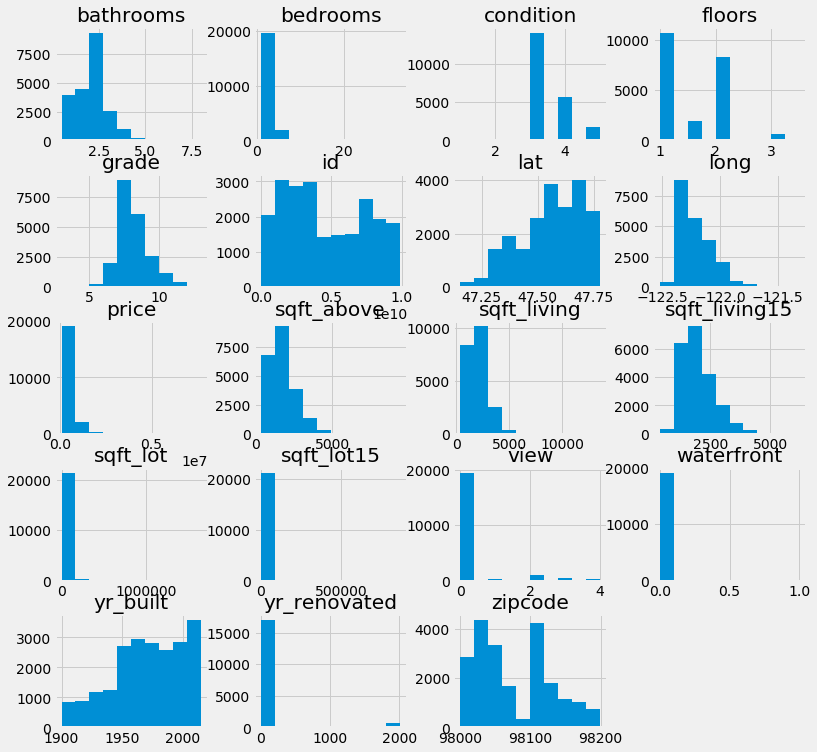

In [118]:
# A general view of the shape of our columns data
_ = kc_housing.hist(figsize=(12,12))

In [119]:
# A very large (and slow) scatter matrix to look at all the potential relationships.

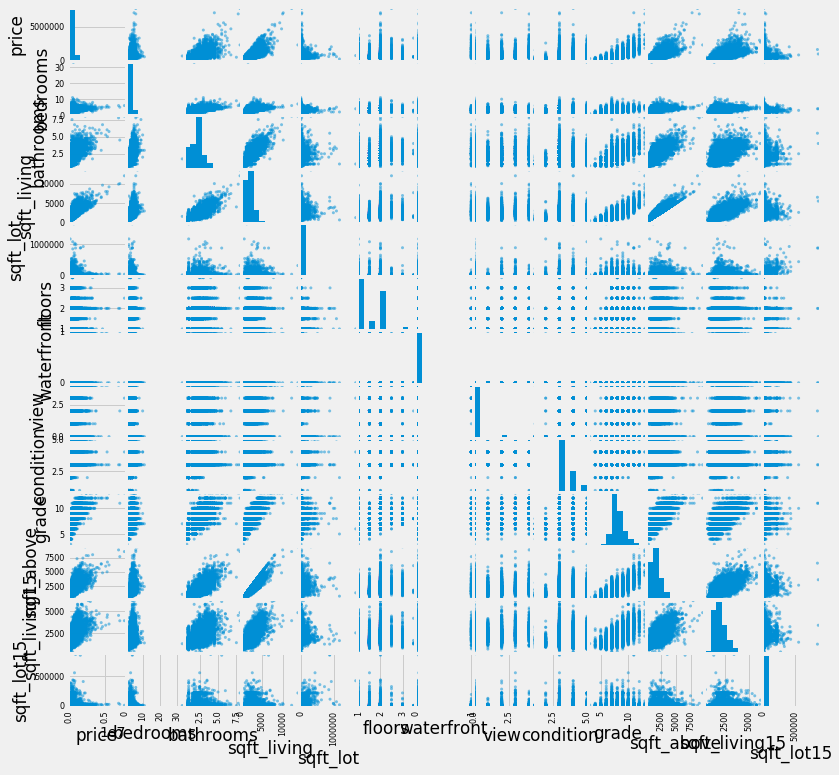

In [120]:
potential_cols = ['price','bedrooms','bathrooms','sqft_living','sqft_lot','floors',
                     'waterfront', 'view','condition','grade','sqft_above','sqft_basement',
                     'sqft_living15','sqft_lot15']
    
_ = pd.plotting.scatter_matrix(kc_housing[potential_cols], figsize=(12,12))

### Scrubbing our data

#### Notes on data cleaning and organizing:
Dropping for now:
* Id: Does not feel necessary for our exploration and will drop this column

* Date: Going to use for some computations, but not do not need the variable on its own.
* Sqft_above: With ample other features for our property size, we decided to pass on using the characteristic for the time being as it is so highly correlated to other features that feel can significantly contribute to our model, like sqft_living.
* Latitude & Longitude: for location purses, we are going to do some exploring with the ZIP code.

In [121]:
kc_measures = kc_housing.drop(['id','date','sqft_above','lat','long'], axis=1).copy()

Cleaning NaN values:
* Waterfront: data is both incomplete and appears to be very primarily negative. Since the value is already binary, we are marking all the NaN values negative as to match to majority. Since it is so skewed, we will re-evaluate its utitlity later.
* Yr_renovated: To handle missing values, we collapsed this variable into binary for denoting renovation (True), or no value or no listed renovation year (False). Similar to waterfront, the majority did not have this value.
* View: The view variable has a couple issues. First, there are some null values in this column.  Since there are only 63 and we have a significant amount of other rows to work with, we dropped these rows.  Second, the value for 'view' seems like a small difference between those with and without views, so it felt more useful to collapse the granuality of number of views to a simple binary for "viewed" (True), "not viewed"(False

TODO (Lee) Merge discuss - changes to wording in view notes in this cell, to align drop/rename comments

In [122]:
kc_measures['waterfront'] = kc_measures['waterfront'].fillna(0.0)

kc_measures['renovated'] = np.where(kc_measures['yr_renovated']>0, 1, 0) 
kc_measures.drop('yr_renovated', axis=1, inplace=True)

kc_measures['view'] = kc_measures['view'].dropna(axis=0)
kc_measures['view'] = np.where(kc_measures['view']> 0, 1, 0)

Other data errors:
* Sqft_basement: In exploring this column, we found that some were marked with a question mark instead of a value. It appears that this column was a computation from sqft_living. Our decision was to test this variable as a binary value equating to having a basement(True), or no basement listed (False)

In [123]:
kc_measures['sqft_basement'] = kc_measures['sqft_basement'].str.replace('?', '0.0').astype('float')

In [124]:
kc_measures['basement'] = np.where(kc_measures['sqft_basement'] > 0, 1, 0)
kc_measures.drop('sqft_basement', axis=1, inplace=True)

Potential solutions for ZIP Code:
* Creating dummy variables for each individual ZIP code. This may subdivide things too much, but can expirment with it. 
* Trying a simple binary "In Seattle"-> True, "Not Seattle"-> False. A slimmer option, but might not provide the subltey of neighborhood variation.

In running tests of both, our ZIP codes as dummy variables appeared to more positively effect the metrics we were monitoring (R-Squared & RMSE), so we went with the dummy variables.  Below shows the process used for the "In Seattle" variation.

TODO (Lee) Merge discuss - logical flow of discussion here of the "in running tests ..." portion of this cell

In [125]:
df_zipcode_dums = pd.get_dummies(kc_measures['zipcode'])
kc_measures_wzip = pd.concat([kc_measures, df_zipcode_dums], axis=1)

# TODO (Lee) Merge discuss - consider one-hot encoding if going to transfer to py file

In [126]:
# seattle_zips = [98101, 98102, 98104, 98105, 98108, 98109, 98112, 98113, 98114, 98117, 98103, 98106, 98107,
#                 98111, 98115, 98116, 98118, 98119,98121, 98125, 98126, 98132, 98133, 98138, 98139, 98141, 
#                 98122, 98124, 98127, 98129, 98131, 98134, 98136, 98144, 98145, 98148, 98155, 98160, 98161, 
#                 98164, 98165, 98168, 98170, 98146, 98154, 98158, 98166, 98174, 98175, 98178, 98190, 98191,
#                 98177, 98181, 98185, 98188, 98189, 98194, 98195, 98199,98198]

In [127]:
# kc_measures['in_seattle'] = kc_measures['zipcode'].map(lambda x: 1 if x in seattle_zips else 0)
# kc_measures.drop('zipcode', axis=1, inplace=True)

Creating a Feature from Year Built:
* Creating scalar values for the year value for "newness" of yr_built (absolute value of difference from 1899)

In [128]:
kc_measures['yr_built_scalar_1899refyr'] = kc_measures['yr_built'].apply(lambda x: abs(1899-x))
kc_measures.drop('yr_built', axis=1, inplace=True)

# TODO (Lee) Merge discuss - change varname here to yr_built_1899refyr, or even to leave as age

Further notes:
* Bedrooms: The data appears complete, though has some heavy outliers on the higher end (one with 33 bedrooms!) which may need to be min-max standardized
* Bathrooms: Comporable to bedrooms, may need to be adjusted for outliers, but complete.
* Yr_built: To make this column more useful, we are going to convert it into its age in years (subtract current year)
* Yr_renovated: data is fairly incomplete, so might want to skip
* Sqft Living 15: Based on the graphs, it looks like we might find some helpful relationship

Here are the key features we ran our modelling tests on:

In [129]:
kc_measures.columns
# Change name - yr_renovated_new',  'waterfront_new',  'view_new',

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'zipcode', 'sqft_living15',
       'sqft_lot15', 'renovated', 'basement', 'yr_built_scalar_1899refyr'],
      dtype='object')

### Modelling

### Our first ugly child - A single linear regression model

Notes on this regression:
* We put both values on a standard scale just to see the effect and get an RMSE that might be more proportionally readble. 

In [130]:
# Setting variables
X = kc_measures[['sqft_living']]
y = kc_measures[['price']]

In [131]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Create model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = linreg.predict(X_test)

In [132]:
 # See the R Squared score for on our test data
r2 = r2_score(y_test, y_hat_test)

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
test_rmse = np.sqrt(test_mse)

print(f"RMSE: {test_rmse}\nR2: {r2}")

RMSE: 271171.8948881409
R2: 0.467149639565424


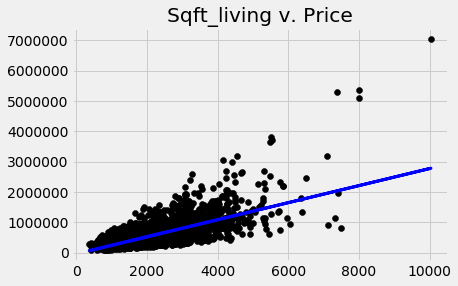

In [133]:
# Plotting
fig, ax = plt.subplots()
ax.scatter(X_test, y_test,  color='black')
ax.plot(X_test, y_hat_test, color='blue', linewidth=3)
ax.set_title('Sqft_living v. Price')
plt.show()

### Viola! 

What we learned from this test:
* On its own, sqft_living does appear to be on the right track of variables to help predict price, based on its scoring and a brief assessment of the visualization.

Potential mental breakdown of values as groups of characteristics:
* Size - sqft_living, sqft_lot, basement, sqft_lot15, sqft_living15
* Structure - bedrooms, bathrooms, floors, waterfront, view, condition, grade, renovated, basement
* Location - zipcode

### Creating some multivariate regression models

We made a quick function to help do the following for us:
1. Seperate out the Y ('price') and converting to log values (just for ease of reading) 
2. Setting our X (all other dataframe variables)
2. Create a train-test split on that data.
3. Run the training data through the linear regression function. 
4. Return a set of useful statistics to review their performance (R-Squared, MSE, RMSE, MAE)

In [134]:
def lin_regress_summary(kc):

    y = kc['price']
    X = kc.drop(['price'], axis=1)

    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Create model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Calculate our y hat (how our model performs against the test data held off)
    y_hat_test = model.predict(X_test)
    y_hat_test

    # See the R Squared score
    r2 = r2_score(y_test, y_hat_test)
    print(f"the R^2 score is: {r2}")

    # See our Mean Squared Error
    test_mse = mean_squared_error(y_test, y_hat_test)
    print(f"the test MSE is: {test_mse}")

    # See our Root Mean Squared Error
    test_rmse = np.sqrt(test_mse)
    print(f"the test RMSE is: {test_rmse}")
    
    # See our Mean Absolute Error
    test_mae = mean_absolute_error(y_test, y_hat_test)
    print(f"the test MAE is: {test_mae}")
    
    # Optional OLS test used to look into larger results, but ommitted for space and details:
    # model = sm.OLS(y, X)
    # results = model.fit()
    # print(results.summary())

### Potential modelling based around categories of information:

* Size - sqft_living, sqft_lot, sqft_above, basement, sqft_lot15, sqft_living15, sqft
* Structure - bedrooms, bathrooms, floors, waterfront, view, condition, grade, renovated, basement
* Location - zipcode

In [135]:
#### Testing all variables against price:

In [136]:
lin_regress_summary(kc_measures)

the R^2 score is: 0.6410182894944645
the test MSE is: 42628095738.628845
the test RMSE is: 206465.72533626217
the test MAE is: 137736.59107576348


In [137]:
#### Testing all variables WITH all ZIP codes as dummy variables

In [138]:
lin_regress_summary(kc_measures_wzip)

the R^2 score is: 0.8101558325226264
the test MSE is: 22812624656.31514
the test RMSE is: 151038.48733457027
the test MAE is: 96650.74891493056


Based just on this initial assessment, it appeared that the ZIP codes were a great help to improving our model, both in its representativeness to the data (R^2) and its potential for model prediction (RMSE & MAE).

With that knowledge, we began running several iterations of our variables without the ZIP codes to find the strongest ones, and then adding them along with our ZIP code variables.

First, a couple models based on that simple seperation of characteristics:

kc_m_structure = kc_measures[['price', 'bedrooms', 'bathrooms', 'floors', 
                              'waterfront', 'view', 'condition', 'grade', 
                              'renovated', 'basement']]

#TODO (Lee) Merge discuss - rename from structure, since waterfront, view reflect non-structure characteristics

In [139]:
kc_m_size = kc_measures[['price','sqft_living','sqft_lot',
                         'sqft_living15', 'sqft_lot15']]

In [140]:
lin_regress_summary(kc_m_size)

the R^2 score is: 0.5000438542879467
the test MSE is: 66249001115.114876
the test RMSE is: 257388.81311182675
the test MAE is: 171842.6464211332


In [141]:
kc_m_structure = kc_measures[['price', 'bedrooms', 'bathrooms', 'floors', 
                              'waterfront', 'view', 'condition', 'grade', 
                              'renovated', 'basement']]

#TODO (Lee) Merge discuss - rename from structure, since waterfront, view reflect non-structure characteristics

In [142]:
lin_regress_summary(kc_m_structure)

the R^2 score is: 0.5402486082407325
the test MSE is: 65322953769.50512
the test RMSE is: 255583.55535813552
the test MAE is: 160591.00179355603


Next, we took a quick look at the results of a stepwise selector (function originally found on Learn.co, modified to take in a dataframe, know the 'price' is our key variable, and test the rest):

In [143]:
stepwise_selection(kc_measures)

['floors',
 'grade',
 'view',
 'yr_built_scalar_1899refyr',
 'bathrooms',
 'sqft_living',
 'waterfront',
 'bedrooms',
 'sqft_lot15',
 'condition',
 'sqft_living15',
 'renovated',
 'basement']

Attempted as well with the ZIP codes variables, but in subsetting were marginally as useful as the complete set.

In [144]:
# = pd.concat([kc_measures[['price']], df_zipcode_dums], axis=1)
# stepwise_selection(kc_zips_wprice)

Based on these results, ran several more tests and tried a number of different configurations:

In [145]:
kc_m_step_results = kc_measures[['price','waterfront','grade','yr_built_scalar_1899refyr', 'bathrooms',
                                 'sqft_living', 'bedrooms', 'view', 'sqft_lot15', 'condition',
                                 'floors', 'sqft_living15', 'renovated', 'basement']]

In [146]:
lin_regress_summary(kc_m_step_results)

the R^2 score is: 0.6622882273203908
the test MSE is: 43011134865.72704
the test RMSE is: 207391.26034075554
the test MAE is: 141133.0248398278


In [147]:
kc_m_var_1 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view', 'condition', 'grade',
                            'zipcode', 'sqft_living15','sqft_lot15', 'renovated',
                            'basement', 'yr_built_scalar_1899refyr']]

In [148]:
lin_regress_summary(kc_m_var_1)

the R^2 score is: 0.618185618439312
the test MSE is: 50556155409.69697
the test RMSE is: 224846.9599743278
the test MAE is: 142758.57705923304


In [149]:
kc_m_var_2 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view', 'condition', 'grade', 'zipcode',
                            'sqft_living15','sqft_lot15',  'basement', 'yr_built_scalar_1899refyr']]

In [150]:
lin_regress_summary(kc_m_var_2)

the R^2 score is: 0.6439980870785456
the test MSE is: 49032110299.92193
the test RMSE is: 221431.9541076263
the test MAE is: 142823.89190300796


In [151]:
kc_m_var_3 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot','view', 'condition', 'grade', 'sqft_living15',
                               'sqft_lot15','yr_built_scalar_1899refyr']]

In [152]:
lin_regress_summary(kc_m_var_3)

the R^2 score is: 0.636326685057685
the test MSE is: 46268417201.84356
the test RMSE is: 215100.9465386974
the test MAE is: 143406.83887232144


In [153]:
kc_m_var_4 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view',  'grade', 'sqft_living15',
                               'sqft_lot15', 'yr_built_scalar_1899refyr']]

In [154]:
lin_regress_summary(kc_m_var_4)

the R^2 score is: 0.6194094755099582
the test MSE is: 51688849282.11071
the test RMSE is: 227351.81829514957
the test MAE is: 144526.04105673643


In [155]:
kc_m_var_5 = kc_measures[['price','waterfront', 'view', 'bedrooms',
                      'sqft_living', 'grade', 'yr_built_scalar_1899refyr']]

In [156]:
lin_regress_summary(kc_m_var_5)

the R^2 score is: 0.6500747828919111
the test MSE is: 45402147257.98083
the test RMSE is: 213077.79625756605
the test MAE is: 146268.99299964623


With keeping in mind some of what we saw from our model tests, we ran further tests including our ZIP code dummy variables combined with our other variable measures:

In [157]:
kc_use_6 = kc_measures[['price','waterfront', 'view', 'bedrooms',
                      'sqft_living', 'grade', 'yr_built_scalar_1899refyr']]
kc_m_var_6 = pd.concat([kc_use_6, df_zipcode_dums], axis=1)

In [158]:
lin_regress_summary(kc_m_var_6)

the R^2 score is: 0.7974476940710522
the test MSE is: 29821543366.382698
the test RMSE is: 172689.1524282365
the test MAE is: 99432.93106011285


In [159]:
kc_use_7 = kc_measures[['price','sqft_living','bedrooms','bathrooms', 'grade', 'sqft_lot']]
kc_m_var_7 = pd.concat([kc_use_7, df_zipcode_dums], axis=1)

In [160]:
lin_regress_summary(kc_m_var_7)

the R^2 score is: 0.7196524223764784
the test MSE is: 40281975425.105736
the test RMSE is: 200703.7005765109
the test MAE is: 109860.66978366993


Based on all our variations, it appears that our model for "kc_m_var_6" has the best potential.  From here, we will further check and test our model.

### Multicollinearity testing and cross valuation

We reviewed the ZIP codes as well, and did not find any individual values to be significantly effected by multicollinearity.

To check our other selected variables, we are looked for multicollinearity through the table below and explored the heatmap:

In [161]:
kc_use_6.corr()

,price,waterfront,view,bedrooms,sqft_living,grade,yr_built_scalar_1899refyr
price,1.000000,0.264306,0.356243,0.308787,0.701917,0.667951,0.053953
waterfront,0.264306,1.000000,0.248683,-0.002127,0.104637,0.082818,-0.024487
view,0.356243,0.248683,1.000000,0.079232,0.268465,0.235252,-0.063826
bedrooms,0.308787,-0.002127,0.079232,1.000000,0.578212,0.356563,0.155670
sqft_living,0.701917,0.104637,0.268465,0.578212,1.000000,0.762779,0.318152
grade,0.667951,0.082818,0.235252,0.356563,0.762779,1.000000,0.447865
yr_built_scalar_1899refyr,0.053953,-0.024487,-0.063826,0.155670,0.318152,0.447865,1.000000


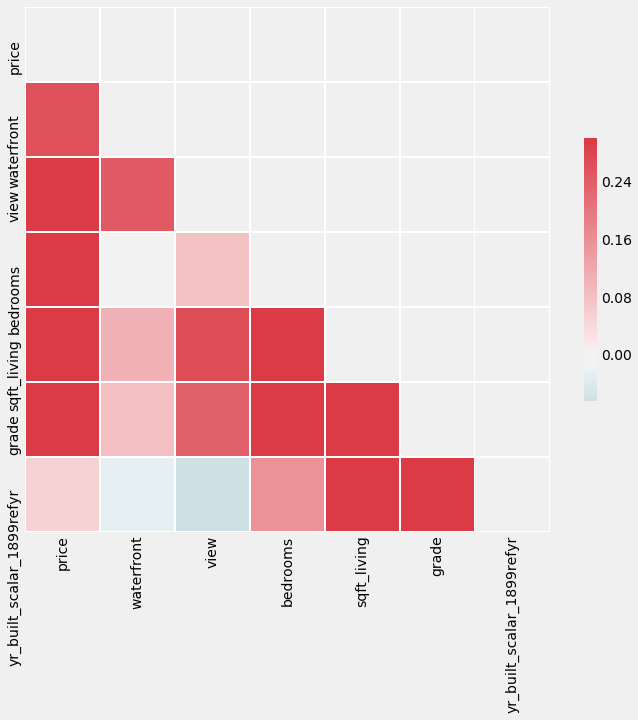

In [162]:
#Heatmap view of how the variables relate:
corr = kc_use_6.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Based on this information, it appears that 'grade' is highly correlated with 'sqft_living', which does intrinsically make sense. To conteract that, we decided to drop that feature from our model.

Further, we tried to further look into our potential model features.

In [163]:
kc_model = kc_measures[['price','waterfront','view','bedrooms','sqft_living', 'yr_built_scalar_1899refyr']].copy()

kc_model['bedrooms'] = np.log(kc_model['bedrooms'])

kc_model_complete = pd.concat([kc_model,df_zipcode_dums], axis=1)

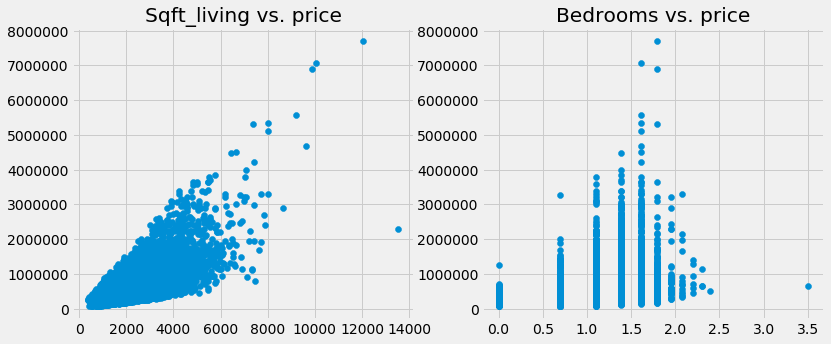

In [164]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

ax[0].scatter(kc_model['sqft_living'], kc_model['price'])
ax[0].set_title("Sqft_living vs. price")

ax[1].scatter(kc_model['bedrooms'], kc_model['price'])
ax[1].set_title("Bedrooms vs. price")

plt.show()

In [165]:
lin_regress_summary(kc_model_complete)

the R^2 score is: 0.7938798482839695
the test MSE is: 27192802516.885124
the test RMSE is: 164902.40300518705
the test MAE is: 103156.89257993345


#### Cross validation with K-Folds

In [166]:
y = kc_model_complete['price']
X = kc_model_complete.drop('price', axis=1)

linreg = LinearRegression()

cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring="neg_mean_squared_error"))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring="neg_mean_squared_error"))

### Graveyard of Calculated Features

The following are a seleciton of features we drafted, modeled with other variables, and found not a significant enough impact to include in our model.

#### Yard Size: all square footage outside of the living area (Sqft_Living - Sqft_Lot)

In [167]:
# kc_measures['yard'] = kc_measures['sqft_living'] - kc_measures['sqft_lot']

#### Seasons: taking the month sold during the year and grouping into four seasons. Tried just months as well, but sales were fairly even by month.

In [168]:
# kc_mod['month'] = kc_mod['date'].apply(lambda x: x[:2]).str.replace('/','').astype(int)

# def quarter(val):
#     if val in range(3):
#         return '1-3'
#     elif val in range(4,7):
#         return '4-6'
#     elif val in range(7,10):
#         return '7-9'
#     elif val in range(10,13):
#         return '10-12'
    
# kc_mod['month'] = kc_mod['month'].apply(lambda x: quarter(x))
# kc_mod['month'].value_counts()
# df_month_dums = pd.get_dummies(kc_mod['month'])
# kc_mod = pd.concat([kc_mod, df_month_dums], axis=1)

#### Distance from Expensive neighborhoods: Based on article found from 2017 with most expensive neighborhoods, create values for distance from those expensive neighborhood centers.  This method we did not finish testing, but feel that some of its subtley may be picked up in ZIP codes 

- original article - https://seattle.curbed.com/2017/10/11/16462132/seattle-cheap-expensive-neighborhoods-buying-home">Original article<a>

In [169]:
# Test for location close to expensive areas
# kc_measures['loc'] = (kc_measures['lat'] + 90) * (180 + kc_measures['long'])
# kc_measures.drop(['lat','long'], axis=1, inplace=True)
# # location = (lat + 90) * 180 + long

# downtown = (47.60806 + 90) * (180 + -122.33611)
# madrona = (47.613274 + 90) * (180 + -122.28887)
# slu = (47.62343 + 90) * (180 + -122.33435)
# eastlake = (47.64708 + 90) * ( 180 + -122.32477)
# queen_anne = (47.63692 + 90) * (180 + -122.35579)
# magnolia = (47.65056 + 90) * (180 + -122.40083)
# first_hill = (47.60864 + 90) *(180 + -122.32679)

# #location = (lat + 90) * 180 + long

# kc_expensive = kc_housing.drop(['id','date','sqft_above'], axis=1).copy()
# kc_expensive['loc'] = (kc_measures['lat'] + 90) * (180 + kc_measures['long'])
# kc_expensive['loc_downtown'] = kc_expensive['loc'].apply(lambda x: x - downtown)

# kc_expensive['loc_madrona'] = kc_expensive['loc'].apply(lambda x: x - madrona)
# kc_expensive['loc_slu'] = kc_expensive['loc'].apply(lambda x: x - slu)
# kc_expensive['loc_eastlake'] = kc_expensive['loc'].apply(lambda x: x - eastlake)
# kc_expensive['loc_queen_anne'] = kc_expensive['loc'].apply(lambda x: x - queen_anne)
# kc_expensive['loc_magnolia'] = kc_expensive['loc'].apply(lambda x: x - magnolia)
# kc_expensive['loc_first_hill'] = kc_expensive['loc'].apply(lambda x: x - first_hill)

In [170]:
  len_X_columns = len(X.columns)
    print(f"{len_X_columns} Features included in model: {X.columns.sort_values()}")

IndentationError: unexpected indent (<ipython-input-170-04ce6a86066b>, line 2)

In [ ]:
def lin_regress_summary(kc):
    """ define input X and y, fit OLS model, output model eval metrics"""
    
    # defines features and target passed to tts/model
    X = kc.drop(['price'], axis=1)
    y = kc.price

    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
    
    # Create model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Calculate our y hat (how our model performs against the test data held off)
    y_hat_test = model.predict(X_test)
    y_hat_test

    # See the R Squared score for our test data
    r2 = r2_score(y_test, y_hat_test)
    print(f"the r2 score is: {r2}")

    # See our Squared Mean Error score for data
    test_mse = mean_squared_error(y_test, y_hat_test)
    print(f"the test MSE is: {test_mse}")

    test_mse = np.sqrt(test_mse)
    print(f"the test RMSE is: {test_mse}")
    
    test_mae = mean_absolute_error(y_test, y_hat_test)
    print(f"the test MAE is: {test_mae}")
    
    #TODO (Lee) - turn the statsmodel output into an optional argument?
    model_1 = sm.OLS(y, X)
    results = model_1.fit()
    print(results.summary())
    
    # produces qqplot of y-hat from statmodel model
    resid1 = results.resid
    print(f"qqplot of yhat from stasmodel model")
    fig = sm.graphics.qqplot(resid1, line='45', fit=True)
    fig.show()
    
    # k-fold cross-val on X_train and y_train
    cv_10_results_10_RMSE = np.mean(np.sqrt(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_squared_error"))))
    print(f"k-fold cross val 10 RMSE: {cv_10_results_10_RMSE}")
    
    cv_10_results_10_MSE = np.mean(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_squared_error")))
    print(f"k-fold cross val 10 MSE: {cv_10_results_10_MSE}")
    
    cv_10_results_10_MAE = np.mean(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_absolute_error")))
    print(f"k-fold cross val 10 MAE: {cv_10_results_10_MAE}")

### separates linreg function into individual functions

In [ ]:
def define_x_y(pass)
    """defines features and target passed to tts/model"""
    X = kc.drop(['price'], axis=1)
    y = kc.price
    len_X_columns = len(X.columns)
    print(f"{len_X_columns} Features included in model: {X.columns.sort_values()}")

In [ ]:
def crossval_technique(x, y, test_size)
    """ Create train-test split """
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
    print((f"cross-val technique is:  Features included in model: {X.columns.sort_values()}")

In [ ]:
def model_fit(pass)
    """Create model"""
    model = LinearRegression()
    model.fit(X_train, y_train)

In [ ]:
def calculate_y_hat()
    """ Calculate our y hat (how our model performs against the test data held off)"""
    y_hat_test = model.predict(X_test)
    y_hat_test

In [ ]:
def calculate_model_eval_metrics(pass)
    """prints model eval metric"""
    # See the R Squared score for our test data
    r2 = r2_score(y_test, y_hat_test)
    print(f"the r2 score is: {r2}")

    # See our Squared Mean Error score for data
    test_mse = mean_squared_error(y_test, y_hat_test)
    print(f"the test MSE is: {test_mse}")

    test_mse = np.sqrt(test_mse)
    print(f"the test RMSE is: {test_mse}")
    
    test_mae = mean_absolute_error(y_test, y_hat_test)
    print(f"the test MAE is: {test_mae}")

In [ ]:
def 
    """defines features and target passed to tts/model"""
    X = kc.drop(['price'], axis=1)
    y = kc.price
    len_X_columns = len(X.columns)
    print(f"{len_X_columns} Features included in model: {X.columns.sort_values()}")

In [ ]:
def statsmodel_workflow(pass)
# TODO (Lee) - turn the statsmodel output into an optional argument?
    #model = sm.OLS(y, X)
    #results = model.fit()
    #print(results.summary())

In [ ]:
def model_packaged_summary(kc, crossval_params):
    """workflow pipeline/packaging to define input X and y, fit OLS model, output model eval metrics"""
    
    # a = define_x_y(kc)
    x = define_x(kc)
    y = define_y(kc)
    
    b = crossval_technique(x, y, 0.2)
    
    c = model_fit(b)

    d = calculate_y_hat(c)
    
    e = calculate_model_eval_metrics(d)

    return e

the r2 score is: 0.6501529013795871
the test MSE is: 49357384547.92217
the test RMSE is: 222165.2190328679
the test MAE is: 141103.9189389415
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:09:37   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:                   21582   BIC:                         5.921e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


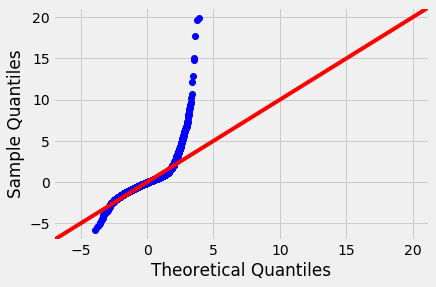

In [427]:
# TODO (Lee) - print in output: name/attributes of y column inputted to model
# TODO (Lee) - debug the varying outputs if run this model repeatedly
mod_test = lin_regress_summary(kc_measures)

In [356]:
lin_regress_summary(kc_measures_wzip)

TypeError: '<' not supported between instances of 'int' and 'str'

In [47]:
kc_m_update1 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'floors','view', 'condition',
                            'grade','sqft_living15', 'sqft_lot15']]

In [161]:
type(statsmodel_model)

NameError: name 'statsmodel_model' is not defined

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6541364585036736
the test MSE is: 49141402368.06891
the test RMSE is: 221678.60151144248
the test MAE is: 137888.09788966278
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:26:32   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:             

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


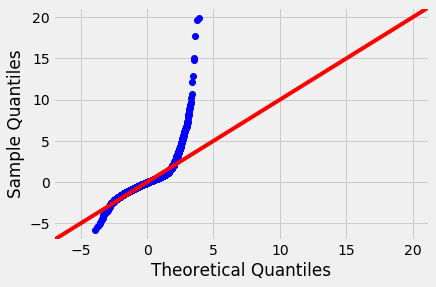

In [318]:
lin_regress_summary(kc_m_update1)

In [319]:
kc_m_update2 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view', 'condition', 'grade',
                            'zipcode', 'sqft_living15','sqft_lot15', 'renovated',
                            'basement', 'yr_built_scalar_1899refyr']]

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6622569170298012
the test MSE is: 43015122559.49486
the test RMSE is: 207400.87405672827
the test MAE is: 141153.1977704936
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:26:44   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:              

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


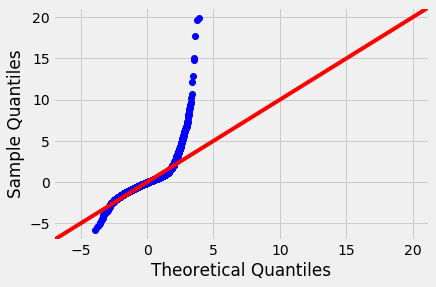

In [320]:
lin_regress_summary(kc_m_update2)

In [321]:
kc_m_update3 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view', 'condition', 'grade', 'zipcode',
                            'sqft_living15','sqft_lot15',  'basement', 'yr_built_scalar_1899refyr']]

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6483564887051567
the test MSE is: 46561221536.93135
the test RMSE is: 215780.49387498247
the test MAE is: 139574.09624227337
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:26:56   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:             

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


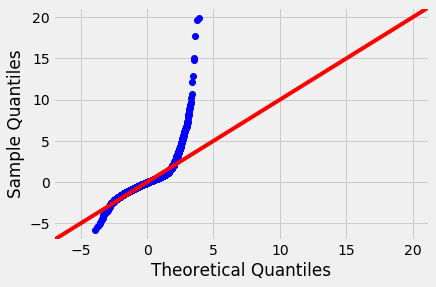

In [322]:
lin_regress_summary(kc_m_update3)

In [323]:
kc_m_update4 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot','view', 'condition', 'grade', 'sqft_living15',
                               'sqft_lot15','yr_built_scalar_1899refyr']]

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6721685809241912
the test MSE is: 45152190807.0519
the test RMSE is: 212490.44874311858
the test MAE is: 139566.14616490525
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:27:13   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:              

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


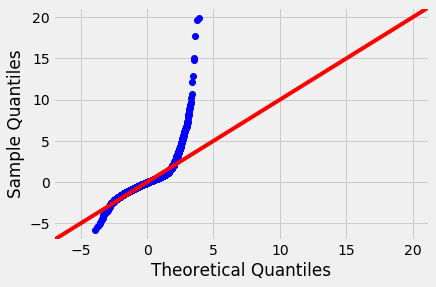

In [324]:
lin_regress_summary(kc_m_update4)

In [325]:
kc_m_update5 = kc_measures[['price', 'bedrooms', 'bathrooms', 'sqft_living',
                            'sqft_lot', 'view',  'grade', 'sqft_living15',
                               'sqft_lot15', 'yr_built_scalar_1899refyr']]

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6700890462882532
the test MSE is: 41972993394.39962
the test RMSE is: 204873.11535289255
the test MAE is: 139702.97622506105
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:27:21   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:             

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


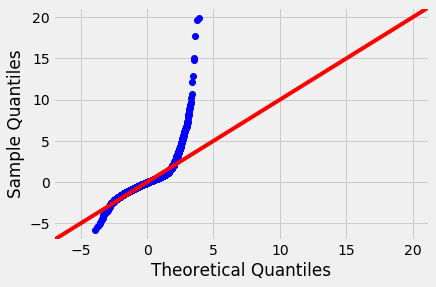

In [326]:
lin_regress_summary(kc_m_update5)

In [327]:
kc_m_update6 = kc_measures[['price','bedrooms', 'bathrooms', 'sqft_living',
                            'condition', 'grade','basement', 'waterfront', 'view']]

15 Features included in model: Index(['basement', 'bathrooms', 'bedrooms', 'condition', 'floors', 'grade',
       'renovated', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15',
       'view', 'waterfront', 'yr_built_scalar_1899refyr', 'zipcode'],
      dtype='object')
the r2 score is: 0.6465979362081258
the test MSE is: 47996323701.96597
the test RMSE is: 219080.6328774088
the test MAE is: 140433.20911886383
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.167e+04
Date:                Wed, 17 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:27:30   Log-Likelihood:            -2.9597e+05
No. Observations:               21597   AIC:                         5.920e+05
Df Residuals:              

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


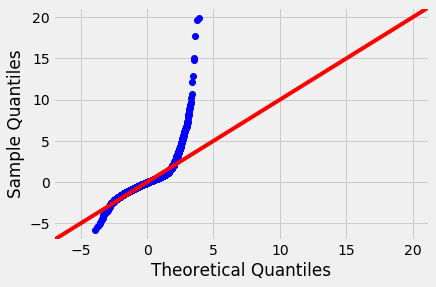

In [328]:
lin_regress_summary(kc_m_update6)

In [ ]:
#transform price using log

In [171]:
kc_use = kc_measures[['price','waterfront', 'view', 'floors',
                      'sqft_living', 'grade', 'yr_built_scalar_1899refyr']]
kc_m_update7 = pd.concat([kc_use, df_zipcode_dums], axis=1)

In [172]:
lin_regress_summary(kc_m_update7)

the R^2 score is: 0.7727910042924816
the test MSE is: 32055265909.325016
the test RMSE is: 179039.84447414216
the test MAE is: 99835.47626229745


the de-transformed y_hat is: [604154.60085298 298407.146048   606183.17715009 ... 176133.5336874
 773424.85294605 217719.30761727]
the r2 score is: 0.8546502635155292
the test MSE is: 0.03814172219367947
the test RMSE is: 0.19529905835328412
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.863
Method:                 Least Squares   F-statistic:                     1815.
Date:                Thu, 18 Apr 2019   Prob (F-statistic):               0.00
Time:                        16:45:59   Log-Likelihood:                 4709.8
No. Observations:               21597   AIC:                            -9268.
Df Residuals:                   21521   BIC:                            -8661.
Df Model:                          75                                         
Covariance Type:            nonrobust          

/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


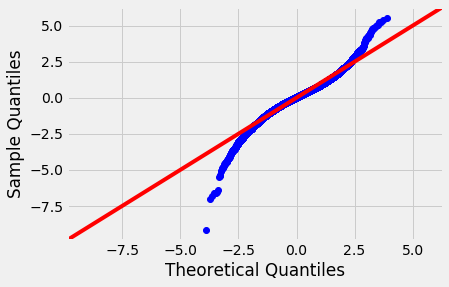

In [207]:
lin_regress_logprice_summary(kc_m_update7)

In [174]:
yhat_test

NameError: name 'yhat_test' is not defined

In [265]:
kc_use = kc_measures[['price','sqft_living','bedrooms','bathrooms',
                      'grade', 'sqft_lot']]
kc_m_update8 = pd.concat([kc_use, df_zipcode_dums], axis=1)

In [266]:
lin_regress_summary(kc_m_update8)

the r2 score is: 0.74038834595689
the test MSE is: 40613086115.20476
the test RMSE is: 201526.88682953638
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     876.6
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:50:08   Log-Likelihood:            -2.9238e+05
No. Observations:               21597   AIC:                         5.849e+05
Df Residuals:                   21522   BIC:                         5.855e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

In [267]:
kc_size = kc_measures[['price','sqft_living','sqft_lot','sqft_living15','sqft_lot15']]

In [268]:
lin_regress_summary(kc_size)

the r2 score is: 0.48706870232512056
the test MSE is: 67992862746.98016
the test RMSE is: 260754.41079103563
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                 2.838e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:50:08   Log-Likelihood:            -3.0002e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21593   BIC:                         6.001e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------

In [269]:
kc_structure = kc_measures[['price','bedrooms', 'bathrooms','floors',
                           'waterfront','view','condition', 'grade',
                           'renovated','basement']]

In [270]:
lin_regress_summary(kc_structure)

the r2 score is: 0.542610991732333
the test MSE is: 63208628350.04705
the test RMSE is: 251413.26208067674
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.825
Model:                            OLS   Adj. R-squared:                  0.825
Method:                 Least Squares   F-statistic:                 1.130e+04
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        17:50:09   Log-Likelihood:            -3.0101e+05
No. Observations:               21597   AIC:                         6.020e+05
Df Residuals:                   21588   BIC:                         6.021e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

### Model fit testing

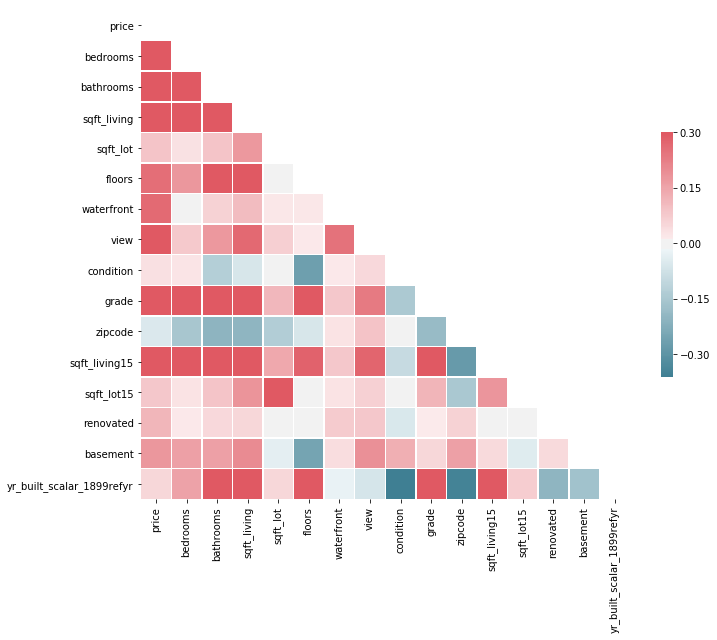

In [273]:
corr = kc_measures.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Looking for multicolinearity

From: https://seattle.curbed.com/2017/10/11/16462132/seattle-cheap-expensive-neighborhoods-buying-home

### Multivariate Linear Regression Models (Normalized just with Standard scalar, but not train-test split)

In [275]:
def ml_summary(df):
    
    scaler = preprocessing.StandardScaler()
    np_scaled = scaler.fit_transform(df)
    df_normalized = pd.DataFrame(np_scaled, columns=df.columns)
    
    y = df_normalized['price']
    X = df_normalized.drop('price', axis=1)
    
    predictors_int = sm.add_constant(X)
    model = sm.OLS(y, predictors_int).fit()
    print(model.summary())

### Plotting practice

### Basic single linear model w/train-test split

In [277]:
scaler = preprocessing.StandardScaler()

X = scaler.fit_transform(kc_measures[['sqft_living']])
y = scaler.fit_transform(kc_measures[['price']])

(array([2.180e+02, 1.457e+03, 3.089e+03, 3.271e+03, 3.056e+03, 2.419e+03,
        2.034e+03, 1.464e+03, 1.157e+03, 8.880e+02, 5.930e+02, 4.180e+02,
        2.380e+02, 1.740e+02, 1.770e+02, 1.350e+02, 1.320e+02, 9.100e+01,
        8.100e+01, 7.900e+01, 4.200e+01, 6.600e+01, 3.800e+01, 4.000e+01,
        2.900e+01, 1.900e+01, 7.000e+00, 2.300e+01, 1.800e+01, 1.600e+01,
        1.500e+01, 1.700e+01, 1.200e+01, 5.000e+00, 8.000e+00, 4.000e+00,
        5.000e+00, 1.000e+01, 7.000e+00, 7.000e+00, 6.000e+00, 0.000e+00,
        6.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 5.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

(array([1.500e+01, 5.900e+01, 2.580e+02, 5.230e+02, 8.350e+02, 1.069e+03,
        1.248e+03, 1.388e+03, 1.480e+03, 1.479e+03, 1.421e+03, 1.416e+03,
        1.268e+03, 1.215e+03, 1.052e+03, 9.540e+02, 8.690e+02, 8.030e+02,
        6.240e+02, 5.430e+02, 4.880e+02, 4.520e+02, 3.340e+02, 3.370e+02,
        2.220e+02, 2.030e+02, 1.790e+02, 1.350e+02, 1.180e+02, 1.130e+02,
        9.200e+01, 6.600e+01, 5.900e+01, 3.200e+01, 3.100e+01, 2.900e+01,
        2.300e+01, 2.600e+01, 1.900e+01, 1.800e+01, 9.000e+00, 1.900e+01,
        7.000e+00, 9.000e+00, 5.000e+00, 7.000e+00, 6.000e+00, 5.000e+00,
        1.000e+00, 4.000e+00, 4.000e+00, 2.000e+00, 4.000e+00, 5.000e+00,
        0.000e+00, 3.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

(array([1.8859e+04, 1.1760e+03, 6.8200e+02, 2.2600e+02, 1.0600e+02,
        8.0000e+01, 7.5000e+01, 3.7000e+01, 2.4000e+01, 2.3000e+01,
        1.9000e+01, 2.9000e+01, 5.9000e+01, 7.7000e+01, 1.7000e+01,
        1.5000e+01, 1.3000e+01, 9.0000e+00, 4.0000e+00, 8.0000e+00,
        3.0000e+00, 3.0000e+00, 3.0000e+00, 7.0000e+00, 2.0000e+00,
        6.0000e+00, 1.0000e+01, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        5.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

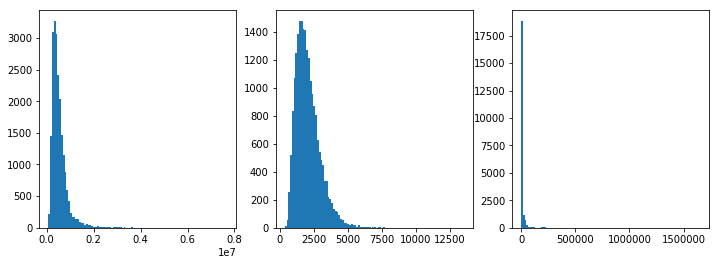

In [276]:
fig, ax = plt.subplots(1, 3, figsize=(12,4))

ax[0].hist(kc_measures['price'], bins=100)
ax[1].hist(kc_measures['sqft_living'], bins=100)
ax[2].hist(kc_measures['sqft_lot'], bins=100)
plt.show()

In [278]:
#Linear regression with SKLearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [279]:
# Create model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [280]:
# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = linreg.predict(X_test)

In [281]:
 # See the R Squared score for on our test data
r2 = r2_score(y_test, y_hat_test)

# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
print(f"RMSE: {test_mse}\nR2: {r2}")

RMSE: 0.5095794761708107
R2: 0.4824189247395204


Text(0.5,1,'Sqft_living v. Price')

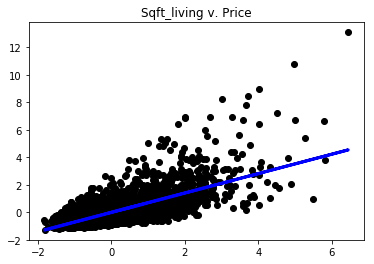

In [282]:
# Plotting
fig, ax = plt.subplots()
ax.scatter(X_test, y_test,  color='black')
ax.plot(X_test, y_hat_test, color='blue', linewidth=3)
ax.set_title('Sqft_living v. Price')
plt.show()

Setting up a shared repo
- Add contributor, 
- git clone, git checkout -b "directory" <- creates branch

In [283]:
result = stepwise_selection(kc_measures, verbose = True)
print('resulting features:')
print(result)

Add  bedrooms                       with p-value 0.0
Add  view                           with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  sqft_living15                  with p-value 0.0
Drop bedrooms                       with p-value 0.429434
Add  grade                          with p-value 0.0
Add  yr_built_scalar_1899refyr      with p-value 0.0


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.


Add  sqft_living                    with p-value 0.0
Add  waterfront                     with p-value 4.65029e-298
Add  bedrooms                       with p-value 8.59314e-78
Add  sqft_lot15                     with p-value 2.32979e-25
Add  condition                      with p-value 4.91628e-12
Add  floors                         with p-value 2.24328e-13
Add  renovated                      with p-value 0.000874365
Add  basement                       with p-value 0.00897782
resulting features:
['view', 'bathrooms', 'sqft_living15', 'grade', 'yr_built_scalar_1899refyr', 'sqft_living', 'waterfront', 'bedrooms', 'sqft_lot15', 'condition', 'floors', 'renovated', 'basement']


* Need to check for multicollinearity 
* Seeing effect of outliers
* What about a location makes it more valuable than others, dummy for zip codes 
* Dollar per square foot
* Distance from Seattle, convert into single value by Lat-Long, calculate distance from 
* Potentially convert scale based to improve values
* When normalizing, don't lose track of the values and what they mean
* NBDime - needed to merge Jupyter notebooks
* R squared is for representation of data, but not generalize, look at test error, RMSE, MAE, RMSLE, pick baseline error, pick metric based on business problem. 
* model.score is good for getting RMSE, but don't limit yourself to that
* Cross validation will answer the question of whether to use more or less of a value
* Stick with RMSE Sklearn, feature selection 

In [176]:
def lin_regress_logprice_summary(kc):

    X = kc.drop(['price'], axis=1)
    y = np.log(kc.price)

    # Create train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Create model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Calculate our y hat (how our model performs against the test data held off)
    y_hat_test = model.predict(X_test)
    y_hat_test
    dollar_unit_error = np.exp(y_hat_test)
    print(f"the de-transformed y_hat is: {dollar_unit_error}")

    # See the R Squared score for our test data
    r2 = r2_score(y_test, y_hat_test)
    print(f"the r2 score is: {r2}")

    # See our Squared Mean Error score for data
    test_mse = mean_squared_error(y_test, y_hat_test)
    print(f"the test MSE is: {test_mse}")

    test_mse = np.sqrt(test_mse)
    print(f"the test RMSE is: {test_mse}")
    
    #TODO (Lee) - turn the statsmodel output into an optional argument?
    model_1 = sm.OLS(y, X)
    results = model_1.fit()
    print(results.summary())
    
    # produces qqplot of y-hat from statmodel model
    resid1 = results.resid
    print(f"qqplot of yhat from stasmodel model")
    fig = sm.graphics.qqplot(resid1, line='45', fit=True)
    fig.show()

In [285]:
# k-fold cross validation

In [536]:
kc_m_update7.head()

,price,waterfront,view,floors,sqft_living,grade,yr_built_scalar_1899refyr,98001,98002,98003,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,221900.0,0.0,0,1.0,1180,7,56,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,0.0,0,2.0,2570,7,52,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,0.0,0,1.0,770,6,34,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,0.0,0,1.0,1960,7,66,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,0.0,0,1.0,1680,8,88,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [400]:
X_kfold = kc_m_update7.drop('price', axis=1)

In [401]:
y_kfold = kc_measures['price']

In [402]:
linreg = LinearRegression()

In [403]:
cv_5_results_1 = np.mean(cross_val_score(linreg, X_kfold, y_kfold, cv=5), scoring="neg_mean_squared_error")

cross_val_score(linreg, X_kfold, y_kfold, cv=10, scoring="neg_mean_squared_error")

TypeError: mean() got an unexpected keyword argument 'scoring'

In [375]:
cv_5_results_1

NameError: name 'cv_5_results_1' is not defined

In [382]:
cv_5_results_2 = (cross_val_score(linreg, X_kfold, y_kfold, cv=5))

In [383]:
cv_5_results_2

array([0.78107021, 0.77763334, 0.78938226, 0.80759529, 0.80230218])

In [404]:
cross_val_score(linreg, X_kfold, y_kfold, cv=10, scoring="neg_mean_squared_error")

array([-3.27671376e+10, -3.28474717e+10, -2.38698852e+10, -3.88941479e+10,
       -2.48364086e+10, -2.42445771e+10, -2.40489475e+10, -2.44676701e+10,
       -2.87333004e+10, -2.57610663e+10])

In [414]:
cv_10_results_1 = np.mean(cross_val_score(linreg, X_kfold, y_kfold, cv=10, scoring="neg_mean_squared_error"))

In [415]:
cv_10_results_1

-28047061246.09373

In [416]:
cv_10_results_2 = np.mean(cross_val_score(linreg, X_kfold, y_kfold, cv=10))

In [417]:
cv_10_results_2

0.7922938471311418

In [406]:
cv_20_results = np.mean(cross_val_score(linreg, X_kfold, y_kfold, cv=20, scoring="neg_mean_squared_error"))

In [407]:
print(np.mean(np.sqrt(abs(cv_5_results))))
print(np.mean(np.sqrt(abs(cv_10_results))))
print(np.mean(np.sqrt(abs(cv_20_results))))

0.8896930244478403
167472.568637654
167260.11379546276


In [ ]:
# k-fold cross-val on X_train and y_train
    cv_10_results_10_RMSE = np.mean(np.sqrt(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_squared_error"))))
    print(f"k-fold cross val 10 RMSE: {cv_10_results_10_RMSE}")
    
    cv_10_results_10_MSE = np.mean(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_squared_error")))
    print(f"k-fold cross val 10 MSE: {cv_10_results_10_MSE}")
    
    cv_10_results_10_MAE = np.mean(abs(cross_val_score(linreg, X_train, y_train, cv=10, scoring="neg_mean_absolute_error")))
    print(f"k-fold cross val 10 MAE: {cv_10_results_10_MAE}")l

In [296]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [297]:
pd.set_option('display.max_rows', 500)

In [298]:
# kc_measures_kc_housing.drop(['id','date','sqft_above','lat','long'], axis=1).copy()

In [299]:
kc_housing.date.dtype

dtype('O')

In [300]:
kc_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


Dependent variable transformed
In this model, the dependent variable is in its log-transformed state, and the independent variable is in its original metric. Comparing the coefficient for census to that obtained in the prior model, we note that there is a big difference in coefficients; however, we must recall the scale of the dependent variable changed states. In such models where the dependent variable has been log-transformed and the predictors have not. To interpet the amount of change in the original metric of the outcome, we first exponentiate the coefficient of census to obtain exp(0.00055773)=1.000558. To calculate the percent change, we can subtract one from this number and multiply by 100. Thus, for a one unit increase in the average daily number of patients (census), the average length of stay (length) increases by 0.06 percent.

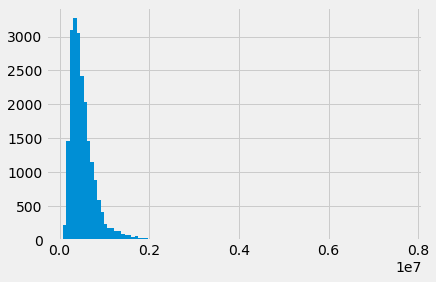

In [479]:
X = kc_measures.price.hist(bins=100)

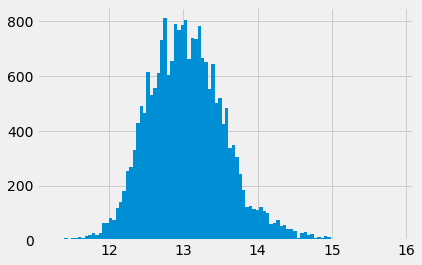

In [480]:
# natural log (logarithm in base e) is the inverse of the exponential function, so that log(exp(x)) = x
X_log = (np.log(kc_measures.price).hist(bins=100))

Text(0.5,1,'Figure 2: log-transformed target (price column)')

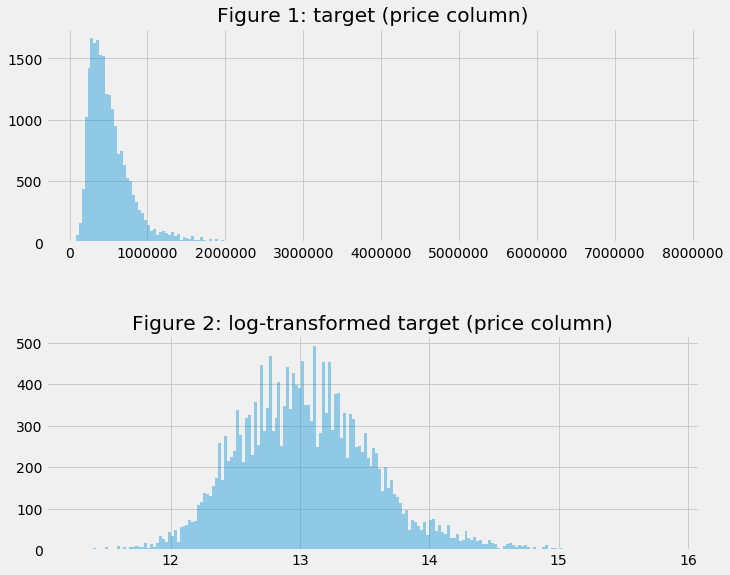

In [591]:
X = kc_measures.price
X_log = np.log(kc_measures.price)
X = kc_measures.price

fig, ax = plt.subplots(2, 1, figsize=(10,8))
fig.tight_layout(h_pad=5)
grid = plt.GridSpec(2, 1, hspace=10)

# kwargs = dict(histtype='stepfilled', alpha=0.3, normed=True, bins=40)
ax[0].hist(X, bins=200, alpha=0.4)
ax[1].hist(X_log, bins=200, alpha=0.4)
ax[0].set_title('Figure 1: target (price column)')
ax[1].set_title('Figure 2: log-transformed target (price column)')
# fig.tight_layout()

# plt.show()
# ax.hist(X_log) # histtype='stepfilled', bins=100, label=['log_X'])
# plt.hist(x1, histtype='stepfilled', alpha=0.3, normed=True, bins=40)
# histtype='stepfilled'

In [111]:
(np.exp(.00055) - 1) * 100

0.05501512777330575

In [ ]:
# Sandbox

In [181]:
kc_use = kc_measures[['price','waterfront', 'view', 'floors',
                      'sqft_living', 'grade', 'yr_built_scalar_1899refyr']]
kc_m_update7 = pd.concat([kc_use, df_zipcode_dums], axis=1)

In [182]:
kc_m_update7.columns

Index([                    'price',                'waterfront',
                            'view',                    'floors',
                     'sqft_living',                     'grade',
       'yr_built_scalar_1899refyr',                       98001,
                             98002,                       98003,
                             98004,                       98005,
                             98006,                       98007,
                             98008,                       98010,
                             98011,                       98014,
                             98019,                       98022,
                             98023,                       98024,
                             98027,                       98028,
                             98029,                       98030,
                             98031,                       98032,
                             98033,                       98034,
                         

In [185]:
y_sandbox = kc_m_update7.price

In [186]:
y_sandbox

0         221900.0
1         538000.0
2         180000.0
3         604000.0
4         510000.0
5        1230000.0
6         257500.0
7         291850.0
8         229500.0
9         323000.0
10        662500.0
11        468000.0
12        310000.0
13        400000.0
14        530000.0
15        650000.0
16        395000.0
17        485000.0
18        189000.0
19        230000.0
20        385000.0
21       2000000.0
22        285000.0
23        252700.0
24        329000.0
25        233000.0
26        937000.0
27        667000.0
28        438000.0
29        719000.0
           ...    
21567     399950.0
21568     380000.0
21569     270000.0
21570     505000.0
21571     385000.0
21572     414500.0
21573     347500.0
21574    1220000.0
21575     572000.0
21576     475000.0
21577    1090000.0
21578     350000.0
21579     520000.0
21580     679950.0
21581    1580000.0
21582     541800.0
21583     810000.0
21584    1540000.0
21585     467000.0
21586     224000.0
21587     507250.0
21588     42

In [201]:
X = kc_m_update7.drop(['price'], axis=1)

In [202]:
y = np.log(y_sandbox)

In [ ]:
# lin_regress_summary(kc_m_update7)

In [ ]:
# lin_regress_logprice_summary(kc_m_update7)

In [203]:
# Create train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [204]:
# Create model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [205]:
# Calculate our y hat (how our model performs against the test data held off)
y_hat_test = model.predict(X_test)
y_hat_test
dollar_unit_error = np.exp(y_hat_test)
print(f"the de-transformed y_hat is: {dollar_unit_error}")

the de-transformed y_hat is: [264463.96954469 382720.14419524 507913.87968812 ... 624118.13182444
 649134.98081668 884405.04541494]


In [206]:
type(y_hat_test)

numpy.ndarray

In [ ]:
# Calculate the exponential of all elements in the input array.

In [200]:
y_hat_test

array([13.01778062, 12.38183849, 12.8224939 , ..., 13.5781512 ,
       13.50396401, 12.66776299])

In [197]:
a = np.exp(y_hat_test)
a

array([450350.12594831, 238431.77402501, 370457.45873151, ...,
       788707.8056884 , 732313.52519491, 317350.77751849])

In [198]:
b = a*2
b

array([ 900700.25189662,  476863.54805003,  740914.91746302, ...,
       1577415.6113768 , 1464627.05038981,  634701.55503697])

In [199]:
c = np.sqrt(b)
c

array([ 949.05229144,  690.55307403,  860.76414741, ..., 1255.95207368,
       1210.21776982,  796.68158949])

In [ ]:
# See the R Squared score for our test data
r2 = r2_score(y_test, y_hat_test)
print(f"the r2 score is: {r2}")

In [ ]:
# See our Squared Mean Error score for data
test_mse = mean_squared_error(y_test, y_hat_test)
print(f"the test MSE is: {test_mse}")

In [ ]:
test_mse = np.sqrt(test_mse)
print(f"the test RMSE is: {test_mse}")
    

In [ ]:
#TODO (Lee) - turn the statsmodel output into an optional argument?
model_1 = sm.OLS(y, X)
results = model_1.fit()
print(results.summary())
    

In [ ]:
# produces qqplot of y-hat from statmodel model
resid1 = results.resid
print(f"qqplot of yhat from stasmodel model")
fig = sm.graphics.qqplot(resid1, line='45', fit=True)
fig.show()

- R-square shows the amount of variance of y explained by X. In
this case our model explains ??% of the variance in price.

- Root MSE: root mean squared error, is the standard deviation of the regression. The closer to zero better the fit. 
    
- Adj R2 shows the same as R squared, but adjusted by the # of cases and # of variables.
    - When the # of variables is small and the # of cases is very large then Adj R2 is closer to R2. This provides a more honest association between X and Y than r squared.
    
- coefficie
For each unit increase in expense, price increases/decreases by "coef" units.

- p-values (wo-tail) test the hypothesis that each coefficient is different from 0. To reject this, the p-value has to be lower than 0.05. In this case, we retained features that were statistically significant in explaining price.

t-values test the hypothesis that the coefficient is different from 0. To reject this, you need a t-value greater
than 1.96 (for 95% confidence). You can get the t-values by dividing the coefficient by its standard error. The t values also show the importance of a variable in the model.